In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, pickle, time, warnings, h5py

import numpy as np, pandas as pd, scipy, scipy.stats as stats, tqdm, h5py
from copy import deepcopy as copy

sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
import disk_halo_mstogap as dh_msto
from transformations import func_inv_jac

from multiprocessing import Pool

In [3]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)
from pylab import Rectangle

In [4]:
sys.path.extend(['../utilities/', '../models/'])
import samplers, disk_cone_plcut as dcp, plotting, transformations
from transformations import func_inv_jac, func_labels, label_dict
import sf_utils

# Load as module

In [5]:
from TracerFit import mwfit, int_idx

In [6]:
run_id=4
size = 99900
file = "sample"

model_full = mwfit(sf_bool=False, perr_bool=False)
model_full.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_full_{run_id:03d}.h')

model_sf = mwfit(sf_bool=False, perr_bool=False)
model_sf.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_{run_id:03d}.h')

model_sf_perr = mwfit(sf_bool=False, perr_bool=False)
model_sf_perr.load(f'/data/asfe2/Projects/mwtrace_data/mockmodel/mock_{file}_{size}_sf_perr_{run_id:03d}.h')

# Load data

In [7]:
# Load Sample
sample = {}; true_pars={};
filename = '/data/asfe2/Projects/mwtrace_data/mockmodel/sample.h'
with h5py.File(filename, 'r') as hf:
    subset = np.intersect1d(hf['sample']['source_id'][...], model_full.sample['source_id'], return_indices=True)[1]
    for key in hf['sample'].keys():
        sample[key]=hf['sample'][key][...][subset]
    # Get true parameters
    for key in hf['true_pars'].keys():
        if not key in np.arange(3).astype(str):
            true_pars[int_idx(key)]=hf['true_pars'][key][...]
        else:
            true_pars[int_idx(key)]={}
            for par in hf['true_pars'][key].keys():
                true_pars[int_idx(key)][par]=hf['true_pars'][key][par][...]
for j in range(3): true_pars[j]['w']*=len(sample['source_id'])
    
# Apply Gaia Selection Function
sample['gaiasf_subset'] = sf_utils.apply_gaiasf(sample['l'], np.arcsin(sample['sinb']), sample['m'])[0]

Loading auxilliary data ...
Loading selection function ...
Creating selection function interpolator...
t = 4.286 s
  auxilliary:   4.283 s
          sf:   0.003 s
interpolator:   0.001 s


In [8]:
model_full._generate_fid_pars()
model_full.sample=sample

model_sf._generate_fid_pars()
model_sf.sample=sample

model_sf_perr._generate_fid_pars()
model_sf_perr.sample=sample

# Plot chains

In [9]:
true_params_f = model_full.transform_params(model_full.get_true_params(true_pars))

In [20]:
chains.shape

(56, 5000, 14)

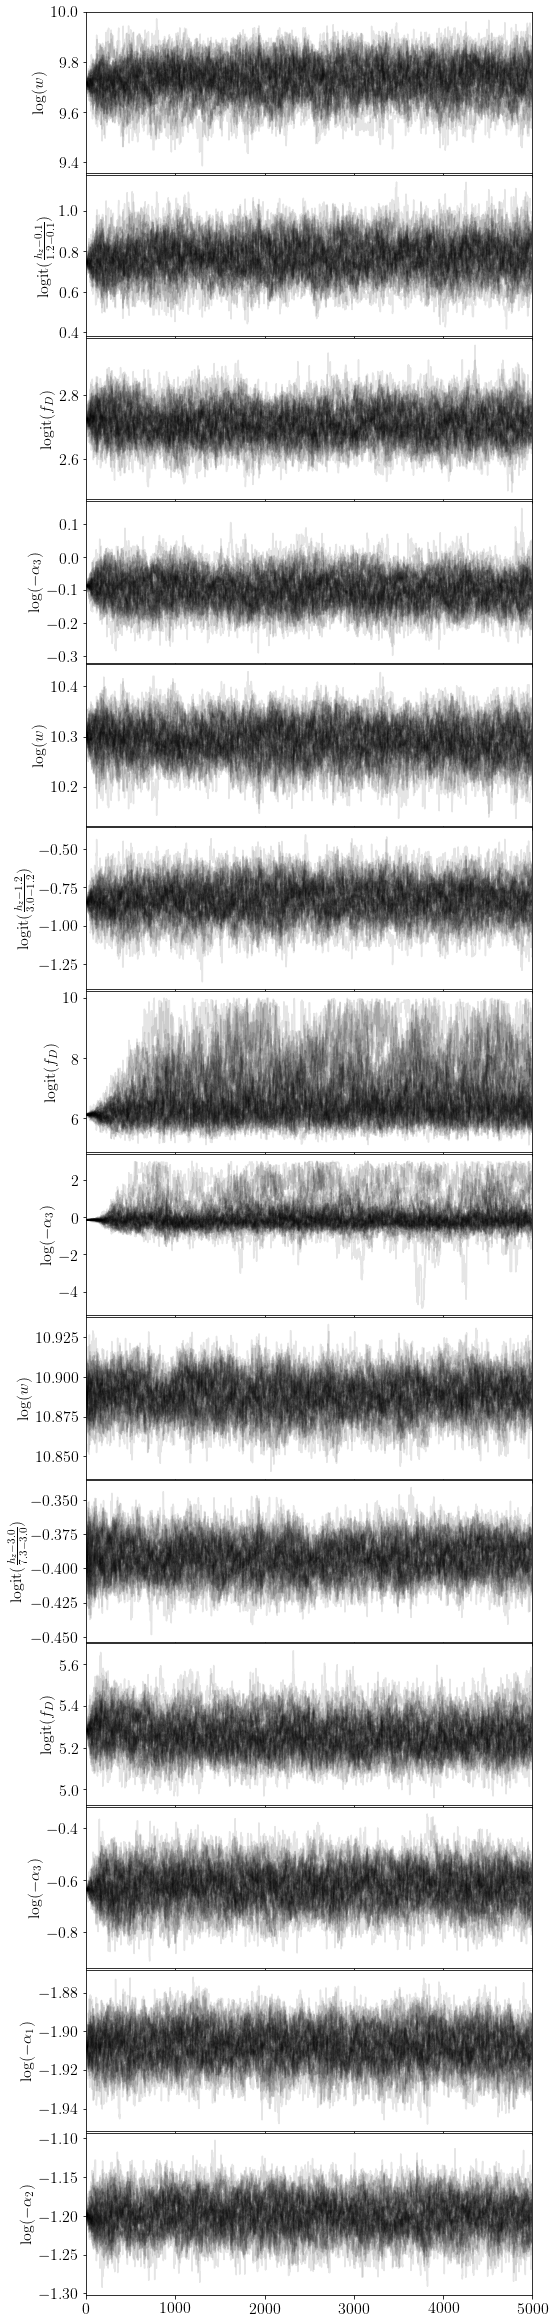

In [22]:
chains = model_full.mcmc_results['chain']['full_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_full.get_labels()
for key in range(chains.shape[2]):
    plt.sca(axes[key])
    for i_walk in range(chains.shape[0]):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
        
plt.xlim(0,chains.shape[1])
plt.subplots_adjust(hspace=0.01)

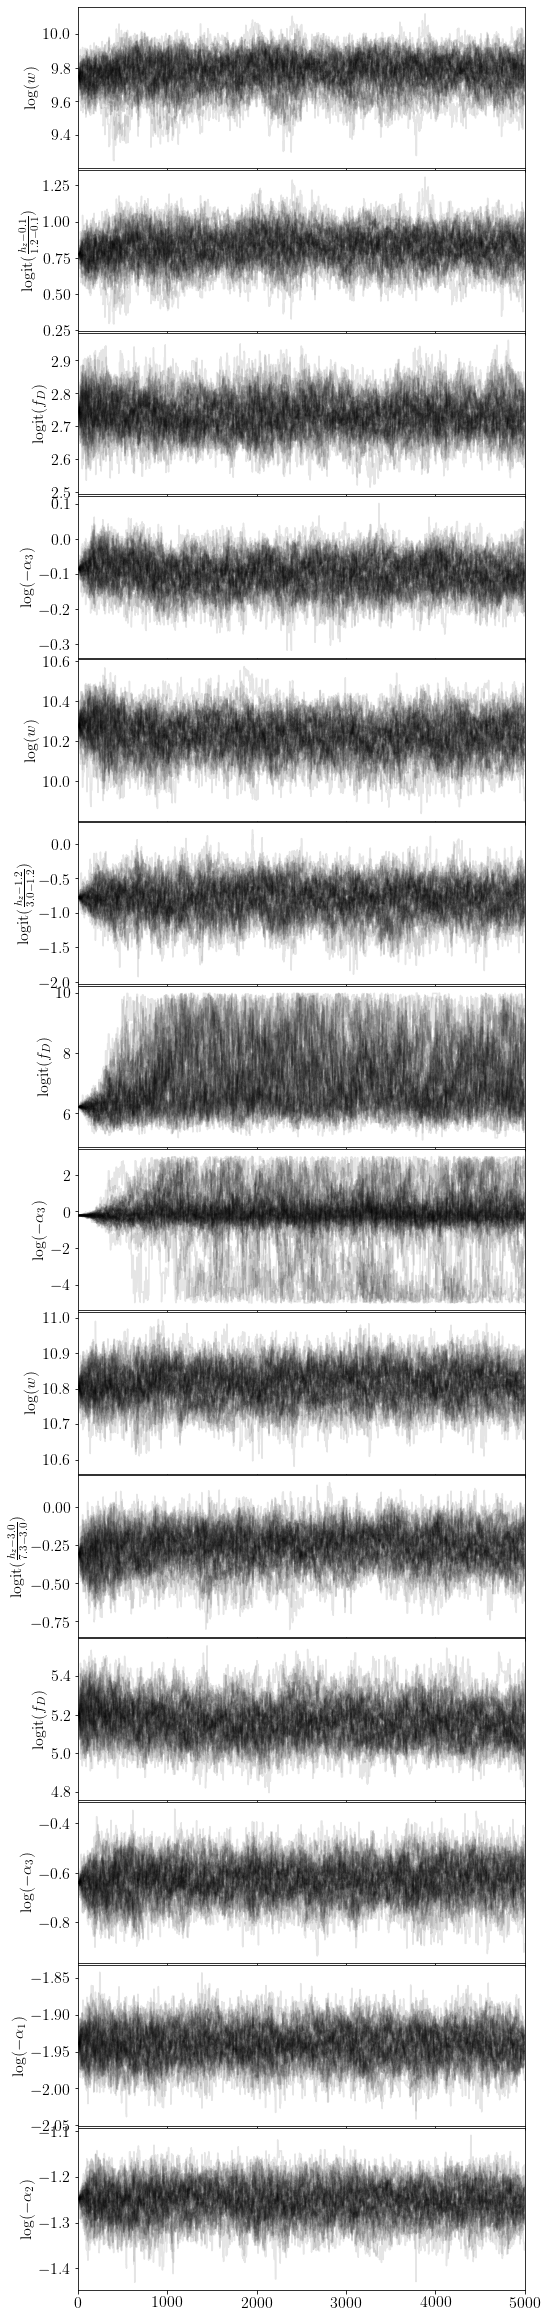

In [23]:
chains = model_sf.mcmc_results['chain']['sf_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf.get_labels()
for key in range(chains.shape[2]):
    plt.sca(axes[key])
    for i_walk in range(chains.shape[0]):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
        
plt.xlim(0,chains.shape[1])
plt.subplots_adjust(hspace=0.01)

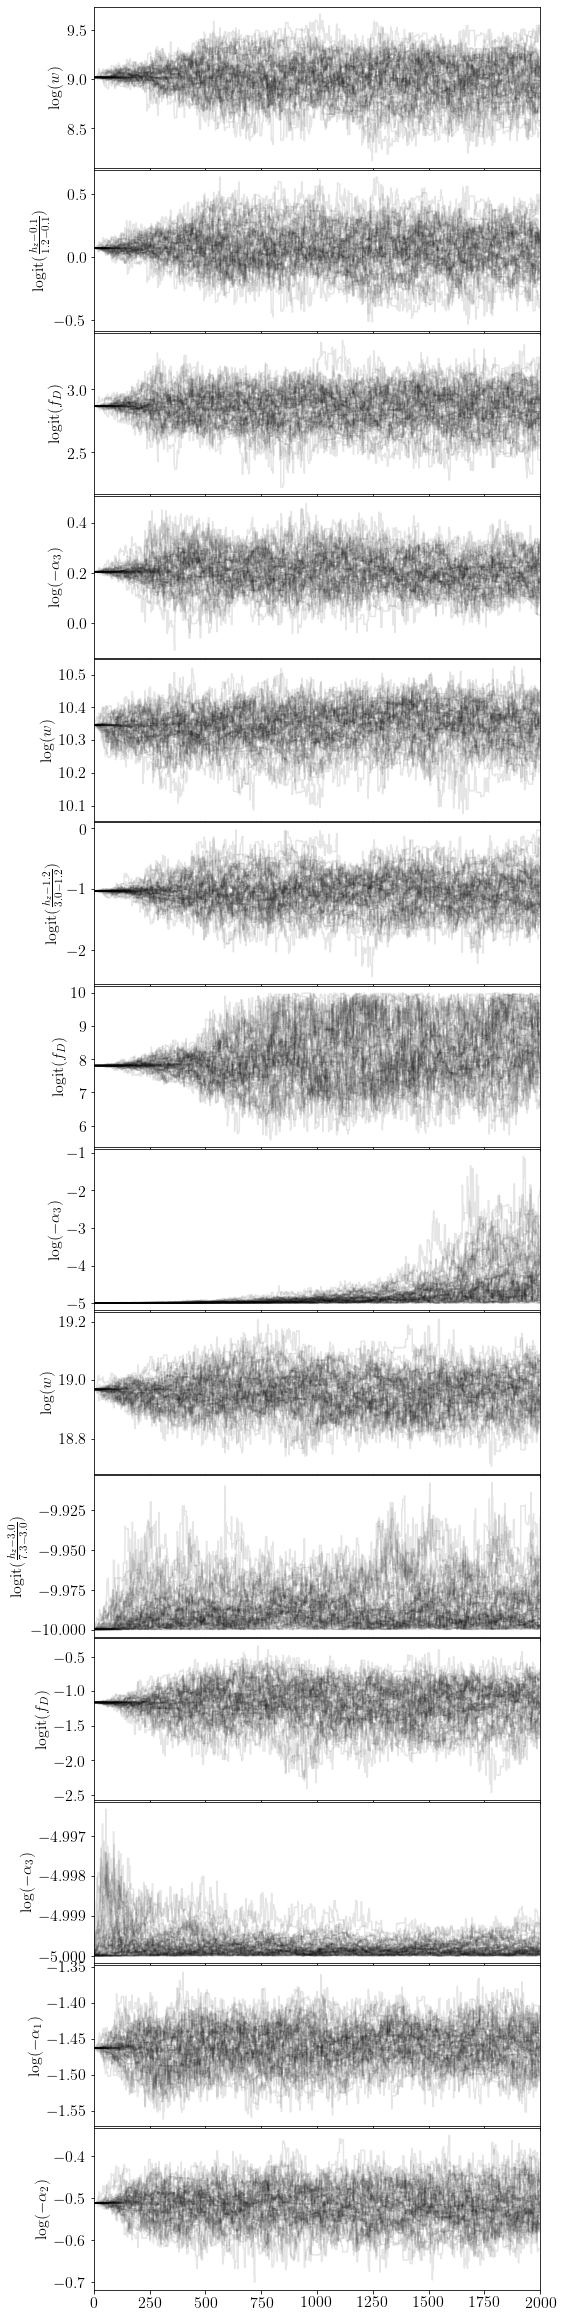

In [24]:
chains = model_sf_perr.mcmc_results['chain']['sf_perr_mcmc'].copy()
nwalk, nstep, ndim = chains.shape

fig, axes = plt.subplots(ndim,1, figsize=(8,3*ndim), sharex=True)

labels = model_sf_perr.get_labels()
for key in range(ndim):
    plt.sca(axes[key])
    for i_walk in range(nwalk):
        plt.plot(chains[i_walk,:,key], c='k', alpha=0.1)
    plt.ylabel(labels[key])
        
plt.xlim(0,nstep)
plt.subplots_adjust(hspace=0.01)